<a href="https://colab.research.google.com/github/Gio1709/paddy_100m_new/blob/master/Guide_bamboo_forest_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sliding Window Combined with CNN for Bamboo forest detection

# Preface

Original Article
**Using deep learning for bamboo forest detection from Google Earth images.**

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

doi: https://doi.org/10.1101/351643

**Note**

Without using specialized  networks like U-net, but with a general CNN for classification, we still can perform a segmentation. The concept originates from the "Patch-based Classification", proposed in the following paper. See the slide below. Combining a sliding window patches with repatative CNN classification allows detection of the tumor region.

Watanabe et al., performed a similar approach to segment bamboo forests from satelite images retreived from google earth.
They express their method as "chopped images", however paying respect to the previous research, I describe this method as "Patch-based Classification" as I interpret the principle is identical. 


*Deep Learning for Identifying Metastatic Breast Cancer*

*Dayong Wang Aditya Khosla⋆ Rishab Gargeya Humayun Irshad Andrew H Beck Beth Israel Deaconess Medical Center, Harvard Medical School**
https://arxiv.org/abs/1606.05718
![image](https://raw.githubusercontent.com/totti0223/deep_learning_for_biologists_with_keras/master/assets/cancer.png)




# Import Libraries

In [0]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight


Using TensorFlow backend.


# Download dataset

In [0]:
## Download and extract dataset
!wget https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip bamboo.zip
!unzip -P bamboo bamboo.zip

--2020-01-08 11:19:30--  https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28240432 (27M) [application/zip]
Saving to: ‘bamboo.zip’

bamboo.zip          100%[===================>]  26.93M   147MB/s    in 0.2s    

2020-01-08 11:19:31 (147 MB/s) - ‘bamboo.zip’ saved [28240432/28240432]

--2020-01-08 11:19:31--  http://bamboo.zip/
Resolving bamboo.zip (bamboo.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘bamboo.zip’
FINISHED --2020-01-08 11:19:31--
Total wall clock time: 0.9s
Downloaded: 1 files, 27M in 0.2s (147 MB/s)
Archive:  bamboo.zip
   creating: bamboo/
   creating: bamboo/test/
  inflating: bamboo/test/test_image.png  
   creating: bamboo/train/
  inf

## Preview

In [0]:
!ls bamboo/train
#image names starting with "b" is image with only bamboo forest.
#image names starting with "o" is image without bamboo forest.

b10.png  b13.png  b2.png  b5.png  b8.png   o1.png  o4.png  o7.png
b11.png  b14.png  b3.png  b6.png  b9.png   o2.png  o5.png  o8.png
b12.png  b1.png   b4.png  b7.png  o10.png  o3.png  o6.png  o9.png


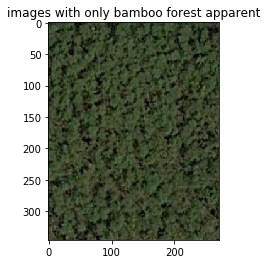

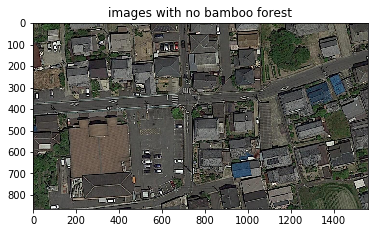

In [0]:
plt.title("images with only bamboo forest apparent")
plt.imshow(imread("bamboo/train/b5.png"))
plt.show()

plt.title("images with no bamboo forest")
plt.imshow(imread("bamboo/train/o10.png"))
plt.show()


# Create "patches" from each image using a sliding window

In [0]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #read imag from path save windows to the specified directory
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".png"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)
        
files = os.listdir("bamboo/train/")
files = [x for x in files if x.endswith(".png")]

for file in files:
    save_directory = "bamboo/chopped"
    file = os.path.join("bamboo/train/",file)
    save_to_folder(file,save_directory)

In [0]:
files = os.listdir("bamboo/chopped/")
files = [x for x in files if x.endswith(".png")]

x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("bamboo/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
x = x.reshape(x.shape[0], -1)
y = np.array(y)
print(x.shape,y.shape)

(3492, 9408) (3492,)


In [0]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [0]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

In [0]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.9415807560137457


In [0]:
import pandas as pd

print(y_test)
print(X_test)
#y_test.value_counts()

[1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1
 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1
 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0
 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1
 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 0 0 1 1 1 1 0 0 1 

In [0]:
# examine the class distribution of the testing set (using a Pandas Series method)
Y_test = pd.Index(y_test)
Y_test.value_counts()

1    649
0    224
dtype: int64

In [0]:
# calculate the percentage of ones
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
y_test.mean()

0.7434135166093929

In [0]:
# calculate the percentage of zeros
1 - y_test.mean()

0.2565864833906071

In [0]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
max(y_test.mean(), 1 - y_test.mean())

0.7434135166093929

In [0]:
# calculate null accuracy (for multi-class classification problems)
Y_test.value_counts().head(1) / len(y_test)

1    0.743414
dtype: float64

In [0]:
# print the first 25 true and predicted responses
print('True:', Y_test.values[0:25])
print('False:', y_pred_class[0:25])

True: [1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1]
False: [1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1]


In [0]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[200  24]
 [ 27 622]]
[[200  24]
 [ 27 622]]


In [0]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.9415807560137457
0.9415807560137457


In [0]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.058419243986254296
0.05841924398625431


In [0]:
recall_rate_bamboo = TP / float(FN + TP)

print(recall_rate_bamboo )
print(metrics.recall_score(y_test, y_pred_class))

0.9583975346687211
0.9583975346687211


In [0]:
recall_rate_bukan_bamboo = TN / (TN + FP)

print(recall_rate_bukan_bamboo)

0.8928571428571429


In [0]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - recall_rate_bukan_bamboo)

0.10714285714285714
0.1071428571428571


In [0]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.9628482972136223
0.9628482972136223


In [0]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.2,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

In [0]:
#compute class weight
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight("balanced",np.unique(train_y),train_y)
print(cw)

# Build and Train CNN

In [0]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

In [0]:
history = model.fit(train_x,train_y,epochs=10,validation_data=(valid_x,valid_y),class_weight=cw)

# Evaluate against Test Data

In [0]:
#read test data
img_path = "bamboo/test/test_image.png"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#create subimages
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#check total images, how many images are tiled at height direction, and width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

In [0]:
#predict the bamboo probability for all the cropped images, and reshape back to its original form.
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

bamboo = np.reshape(predictions,(n_total//n_x,n_x))
bamboo = np.rot90(bamboo)
bamboo = np.flip(bamboo,axis=0)
plt.imshow(bamboo,cmap="jet")

note that each images correspond to 1 pixel of probability, and the size is not compatible with the input images.
we will caculate the ratio factor and resize it.

In [0]:
h_factor = img.shape[0]//bamboo.shape[0]
w_factor = img.shape[1]//bamboo.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(bamboo,(h_factor,w_factor))

print(zoomed.shape)

In [0]:
#result
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()